# Titanic - Machine Learning from Disaster (from Kaggle)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, Normalizer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression

In [2]:
train_df = pd.read_csv('raw_data/train.csv')
test_df = pd.read_csv('raw_data/test.csv')
print(f'Training Set Shape: {train_df.shape}')
print(f'Test Set shape: {test_df.shape}')

Training Set Shape: (891, 12)
Test Set shape: (418, 11)


In [3]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Let's check for duplicated values first.

In [4]:
print(f'There are: {train_df.duplicated().sum()} duplicated rows.')

There are: 0 duplicated rows.


I don't think passenger id, passenger name, or ticket number will have any impact on outcomes. Let's drop these columns.

In [5]:
train_df = train_df.drop(columns=['PassengerId','Name', 'Ticket'])
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C85,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C123,S
4,0,3,male,35.0,0,0,8.0500,NaN,S


Let's check for missing values next.

In [6]:
train_df.isna().sum().sort_values(ascending=False)/len(train_df)

Cabin       0.771044
Age         0.198653
Embarked    0.002245
Survived    0.000000
Pclass      0.000000
Sex         0.000000
SibSp       0.000000
Parch       0.000000
Fare        0.000000
dtype: float64

It seems like age, cabin, and embarked are the only columns missing values. For age, perhaps we can use a mean value after taking a look at the distribution. For cabin, let's see how many uniqe values we have. It may be worth dropping this column. For embarked, let's just fill with the most common value.

In [7]:
print(f"The cabin column contains {train_df['Cabin'].nunique()} unique values.")

The cabin column contains 147 unique values.


Since the Cabin colum is missing over 77% of its values and it contains 147 unique values, I don't think it is going to contribute much to our model. Let's go ahead and drop it.

In [8]:
train_df.drop(columns=['Cabin'], inplace=True)
train_df.shape

(891, 8)

Text(0.5, 1.0, 'Age Distribution of Titanic Passengers')

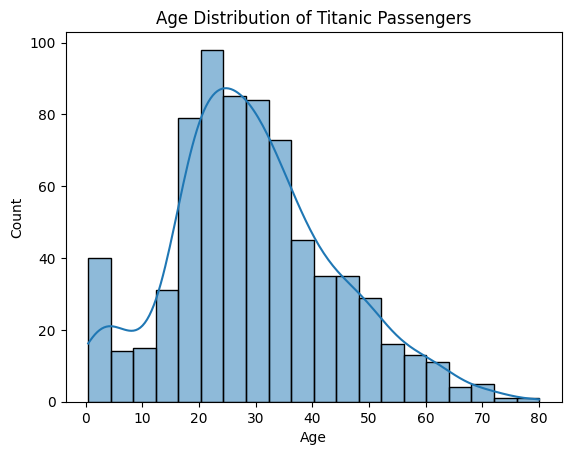

In [10]:
sns.histplot(train_df['Age'], kde=True)
plt.title('Age Distribution of Titanic Passengers')

Given the above age distribution, mean seems like a good strategy to fill in missing values for age.

In [11]:
# Column transformer to fill in missing age values with mean, missing embarked values with most frequent
# one_hot_encode sex and embarked columns

numeric_transformer = make_pipeline(
    SimpleImputer(strategy='mean'),
    StandardScaler()
)

categorical_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse_output=False)
)

preprocessor = make_column_transformer(
  (numeric_transformer, ['Age', 'Fare']),
  (categorical_transformer, ['Sex','Embarked']), remainder='passthrough'
)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Age', 'Fare']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(sparse_output=False))]),
                                 ['Sex', 'Embarked'])])

In [12]:
X= train_df.copy().drop(columns=['Survived'])
y = train_df['Survived']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train.shape

(712, 7)

In [14]:
X_train_preprocesed = preprocessor.fit_transform(X_train)
X_train_preprocesed.shape

(712, 10)

In [15]:
print('Original Training Set')
display(X_train.head(3))
print('Preprocessed Training Set')
display(pd.DataFrame(X_train_preprocesed).head(3))

Original Training Set


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
224,1,male,38.0,1,0,90.0000,S
21,2,male,34.0,0,0,13.0000,S
313,3,male,28.0,0,0,7.8958,S


Preprocessed Training Set


,0,1,2,3,4,5,6,7,8,9
0,0.702798,1.181503,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0
1,0.386164,-0.377118,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0
2,-0.088787,-0.480436,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0


# Now that we have a data preprocessor ready, let's get to modeling

In [119]:
# log_model = LogisticRegression()
# log_model.fit(X_train_preprocesed, y_train)
# log_model

In [18]:
cv_results = cross_validate(estimator=LogisticRegression(),
                    X=X_train_preprocesed,
                    y=y_train,
                    scoring='accuracy',
                    cv=5,
                    n_jobs=-1)

In [19]:
print(f"Mean accuracy score: {cv_results['test_score'].mean()}")

Mean accuracy score: 0.796375455530385


Let's try tweaking a few hyperparameters to see if we can get better results.

In [20]:
search_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

In [21]:
search = GridSearchCV(
    LogisticRegression(max_iter=10000),
    search_params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

In [22]:
search.fit(X_train_preprocesed, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'solver': ['liblinear', 'lbfgs', 'saga']},
             scoring='accuracy')

In [23]:
search.best_score_

0.8005909583374372

In [24]:
search.best_params_

{'C': 1, 'solver': 'liblinear'}

In [25]:
best_log = search.best_estimator_
best_log

LogisticRegression(C=1, max_iter=10000, solver='liblinear')

In [26]:
best_log.score(preprocessor.fit_transform(X_test), y_test)

0.770949720670391

Let's go ahead and make predictions using this model and submit to Kaggle to see the results.

In [27]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [28]:
kaggle_test = test_df.copy().drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
kaggle_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


In [29]:
kaggle_test_processed = preprocessor.transform(kaggle_test)
pd.DataFrame(kaggle_test_processed)

,0,1,2,3,4,5,6,7,8,9
0,1.803546e-01,-0.526461,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0
1,1.062976e+00,-0.542838,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0
2,2.122122e+00,-0.489760,0.0,1.0,0.0,1.0,0.0,2.0,0.0,0.0
3,-3.492182e-01,-0.510004,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0
4,-7.022668e-01,-0.438411,1.0,0.0,0.0,0.0,1.0,3.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
413,-2.508561e-16,-0.522100,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0
414,4.980983e-01,1.469667,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
415,4.627935e-01,-0.537900,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0
416,-2.508561e-16,-0.522100,0.0,1.0,0.0,0.0,1.0,3.0,0.0,0.0


In [30]:
predictions = best_log.predict(kaggle_test_processed)

In [34]:
submission = pd.DataFrame({'PassengerID':test_df['PassengerId'],'Survived':predictions})
submission.set_index('PassengerID', inplace=True)
submission.head()

,Survived
PassengerID,
892,0
893,0
894,0
895,0
896,1


In [35]:
submission.to_csv('raw_data/kaggle_submission.csv', header=True)

A standard logistic regression gave us an accuracy score of around 76% on Kaggle. Let's see if other models can give us better results. I will try the following:
1. Random Forest Classifier
2. KNeighbors Classifier
3. AdaBoostClassifier
4. TensorFlow Neural Network

## Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
cv_resuls = cross_validate(RandomForestClassifier(),
                           X=X_train_preprocesed,
                           y=y_train,
                           scoring='accuracy',
                           cv=5,
                           n_jobs=-1)

In [40]:
print(f'Mean accuracy score: {cv_resuls["test_score"].mean()}')

Mean accuracy score: 0.8146754653796908


Again, let's grid search some of the hyper-parameters to see if we can't get a better score.

In [44]:
search_params = {
    'n_estimators': [100, 500, 1000],
    'min_samples_split': [2, 4, 6],
    'criterion':['gini', 'entropy', 'log_loss']
}

In [45]:
search = GridSearchCV(
    RandomForestClassifier(),
    search_params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

In [46]:
search.fit(X_train_preprocesed, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 500, 1000]},
             scoring='accuracy')

In [47]:
print(search.best_score_)
print(search.best_params_)

0.8314882300797792
{'criterion': 'entropy', 'min_samples_split': 4, 'n_estimators': 100}


Looks like only a very minor improvement in accuracy.

In [48]:
best_forest = search.best_estimator_

In [49]:
forest_pred = best_forest.predict(kaggle_test_processed)

In [50]:
submission = pd.DataFrame({'PassengerID':test_df['PassengerId'],'Survived':forest_pred})
submission.set_index('PassengerID', inplace=True)
submission.head()

,Survived
PassengerID,
892,0
893,0
894,0
895,0
896,0


In [51]:
submission.to_csv('raw_data/random_forest_kaggle_submission.csv', header=True)

## KNeighbors Classifier

In [52]:
from sklearn.neighbors import KNeighborsClassifier

In [53]:
X_train_full = preprocessor.fit_transform(X)
y_train_full = y

In [60]:
# This time, let's use the entire dataset to train since we are using cross validation.
cv_resuls = cross_validate(
    KNeighborsClassifier(),
    X=X_train_full,
    y=y_train_full,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

In [61]:
print(f"Mean accuracy score: {cv_resuls['test_score'].mean()}")

Mean accuracy score: 0.8013621241604418


In [62]:
search_params = {
    'n_neighbors':[3, 5, 6],
    'p':[1, 2, 3]
}

In [63]:
search = GridSearchCV(
    KNeighborsClassifier(),
    search_params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

In [64]:
search.fit(X_train_full, y_train_full)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 6], 'p': [1, 2, 3]},
             scoring='accuracy')

In [65]:
print(search.best_score_)
print(search.best_params_)

0.810344611135522
{'n_neighbors': 6, 'p': 1}


Again, seems like a very small increase in accuracy.

In [66]:
best_neighbor = search.best_estimator_

In [67]:
neighbor_pred = best_neighbor.predict(kaggle_test_processed)

In [68]:
submission = pd.DataFrame({'PassengerID':test_df['PassengerId'],'Survived':neighbor_pred})
submission.set_index('PassengerID', inplace=True)
submission.to_csv('raw_data/kneighbors_kaggle_submission.csv', header=True)

## AdaBoost Classifier

In [69]:
from sklearn.ensemble import AdaBoostClassifier

In [72]:
cv_resuls = cross_validate(AdaBoostClassifier(algorithm='SAMME'),
                           X=X_train_full,y=y_train_full,
                           cv=5,
                           scoring='accuracy',
                           n_jobs=-1)

In [74]:
print(f"Mean accuracy score: {cv_resuls['test_score'].mean()}")

Mean accuracy score: 0.8002385286548239


In [75]:
search_params = {'n_estimators':[50, 100, 1000],
                 'learning_rate': [0.1, 1, 10]}

In [76]:
search = GridSearchCV(
    AdaBoostClassifier(algorithm='SAMME'),
    search_params,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)

In [77]:
search.fit(X_train_full, y_train_full)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(algorithm='SAMME'), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 1, 10],
                         'n_estimators': [50, 100, 1000]},
             scoring='accuracy')

In [78]:
print(search.best_score_)
print(search.best_params_)

0.807005209967987
{'learning_rate': 1, 'n_estimators': 1000}


Again, a very tiny increase in accuracy, but let's go with it.

In [79]:
best_ada = search.best_estimator_

In [80]:
ada_pred = best_ada.predict(kaggle_test_processed)

In [81]:
submission = pd.DataFrame({'PassengerID':test_df['PassengerId'],'Survived':ada_pred})
submission.set_index('PassengerID', inplace=True)
submission.to_csv('raw_data/adaboost_kaggle_submission.csv', header=True)

## Neural Network

In [98]:
from tensorflow.keras import Sequential, layers, Input
from tensorflow.keras.callbacks import EarlyStopping

In [82]:
X_train_full.shape

(891, 10)

In [110]:
model = Sequential()
model.add(Input(shape=(10,)))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(20, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(5, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [112]:
es = EarlyStopping(patience=12)

In [113]:
model.fit(X_train_preprocesed, y_train, batch_size=32, epochs=100, callbacks=[es])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step - accuracy: 0.4905 - loss: 0.7051 
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.8072 - loss: 0.6378
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.7782 - loss: 0.5934
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.8125 - loss: 0.5192
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 598us/step - accuracy: 0.8148 - loss: 0.4652
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.8533 - loss: 0.3978
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - accuracy: 0.8258 - loss: 0.4028
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.8366 - loss: 0.3848
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.8354 - loss: 0.3768
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.8130 - loss: 0.4104
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - accuracy: 0.8254 - loss: 0.4112
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 

In [91]:
X_test_processed = preprocessor.transform(X_test)

In [114]:
results = model.evaluate(X_test_processed, y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.7685 - loss: 0.9562


In [115]:
print(f'Accuracy: {results[1]}')

Accuracy: 0.7821229100227356


In [118]:
neural_pred = model.predict(kaggle_test_processed)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 411us/step


In [147]:
classes = (neural_pred > 0.5)*1
output = classes.flatten()
output

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [148]:
submission = pd.DataFrame({'PassengerID':test_df['PassengerId'],'Survived':output})
submission.set_index('PassengerID', inplace=True)
submission.to_csv('raw_data/NN_kaggle_submission.csv', header=True)

Given that this model's accuracy on the testing set was around 78% but on the kaggle test data it was only 72%, perhaps there is some overfitting going on here. The neural network may have been too deep.

# Final Scores as per Kaggle:
1. Logistic Regrssion Score: 75.8%
2. Random Forest Score: 76.5%
3. KNeighbors Score: 75.3%
4. AdaBoost Socre: 75.6%
5. Tensorflow Neural Network Score: 72.5%